In [2]:
import pandas as pd 
import geopandas as gpd
from scipy.io import mmread
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re 
from tqdm.notebook import tqdm

from sklearn.preprocessing import LabelEncoder

# Toronto 
## Cases

In [2]:
df_tor = pd.read_csv("Data/CasesToronto.csv")
#df_tor["Neighbourhood Name"].value_counts()
#df_tor.Outcome.value_counts()
df_tor.columns

Index(['_id', 'Assigned_ID', 'Outbreak Associated', 'Age Group',
       'Neighbourhood Name', 'FSA', 'Source of Infection', 'Classification',
       'Episode Date', 'Reported Date', 'Client Gender', 'Outcome',
       'Currently Hospitalized', 'Currently in ICU', 'Currently Intubated',
       'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated'],
      dtype='object')

In [3]:
df_tor.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated
0,126705,1,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No,No,No,No
1,126706,2,Sporadic,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,No,No,No,Yes,No,No
2,126707,3,Sporadic,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No,No,No,No
3,126708,4,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No,No,No,No
4,126709,5,Sporadic,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No,No,No,No


In [4]:
df_tor["Episode Date"] = pd.to_datetime(df_tor["Episode Date"])


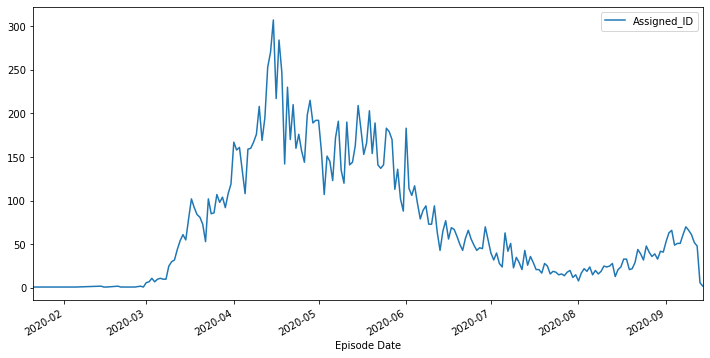

In [15]:
fig, ax = plt.subplots(1,1, figsize = (12, 6))
df_tor.groupby(["Episode Date"]).count().reset_index().plot(x = "Episode Date", y = "Assigned_ID", ax = ax )
fig.savefig("Data/cases.png")

## Traffic

In [17]:
#file_name = "week3Toronto"
file_name = "2019-04-14-Toronto"
traffic_toronto = gpd.read_file("C:/Users/Alessandro/Desktop/GAMA/Workspace/mas/includes/Data/Traffic/"+file_name+".geojson")

In [18]:
traffic_toronto.head()

,jobName,creationTime,userPreference,dateRanges,timeSets,networkName,zoneId,probeSource,segmentId,newSegmentId,speedLimit,frc,streetName,distance,segmentTimeResults,geometry
0,Toronto 2 (2019-04-14 to 2019-04-14),2020-09-28T22:50:15,"{'distanceUnit': 'KILOMETERS', 'includedSpeedL...","[ { ""@id"": 1, ""name"": ""2019-04-14 to 2019-04-1...","[ { ""@id"": 2, ""name"": ""0:00-24:00"", ""dayToTime...",Toronto,America/Toronto,ALL,NaN,None,NaN,NaN,None,NaN,None,None
1,None,None,None,None,None,None,None,None,-2.169083e+18,-0000434f-5000-0400-0000-000000a7daf6,60.0,3.0,Steeles Ave W,46.29,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.52444 43.77480, -79.52388 43.7..."
2,None,None,None,None,None,None,None,None,-2.169083e+18,-0000434f-5000-0400-0000-000000a7daff,60.0,3.0,Steeles Ave W,59.18,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.46387 43.78851, -79.46316 43.7..."
3,None,None,None,None,None,None,None,None,-2.169364e+18,-0000434f-5000-0400-0000-000000a7db02,60.0,4.0,Steeles Ave E,52.77,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.30009 43.82530, -79.30072 43.8..."
4,None,None,None,None,None,None,None,None,-2.169083e+18,-0000434f-5000-0400-0000-000000a7db0d,60.0,3.0,Steeles Ave W,36.22,"[ { ""timeSet"": 2, ""dateRange"": 1, ""harmonicAve...","LINESTRING (-79.53222 43.77324, -79.53211 43.7..."


In [19]:
traffic_toronto = traffic_toronto.iloc[1:]
traffic_toronto = traffic_toronto.drop(["jobName", "creationTime", "userPreference", "dateRanges", "timeSets", "networkName", "zoneId", "probeSource", "segmentId"], axis = 1)

substr_speed = "averageSpeed"
substr_sample_size = "sampleSize"
substr_avg_trav_t = "averageTravelTime"

traffic_toronto["avgSpeed"] = traffic_toronto.apply(lambda row: float(row.segmentTimeResults[row.segmentTimeResults.find(substr_speed) + 15: row.segmentTimeResults.find(substr_speed) +22]), axis = 1  )
traffic_toronto["sampleSize"] = traffic_toronto.apply(lambda row: int(row.segmentTimeResults[row.segmentTimeResults.find(substr_sample_size) + 13: row.segmentTimeResults.find(substr_avg_trav_t) -3]), axis = 1  )
traffic_toronto = traffic_toronto.drop(["segmentTimeResults"], axis = 1)
traffic_toronto.to_file("Data/Traffic/Final/shp/"+ file_name+ ".shp")

DriverIOError: Failed to create file Data/Traffic/Final/shp\2019-04-14-Toronto.shp: No such file or directory

In [ ]:
"""
fig, ax = plt.subplots(1, 1, figsize = (15,8))
traffic_toronto.plot(column = "sampleSize", ax = ax, linewidth=0.2 , legend = True, cmap = "coolwarm",
                    norm= matplotlib.colors.LogNorm(vmin=1, vmax=traffic_toronto.sampleSize.max()))
fig.savefig("Data/Toronto_Traffic_Density.png", dpi = 600)
""";

## Neighbourhood Profiles

**We should choose a subset of the effective number of neighbourhoods**

In [ ]:
bbox = (-79.6491, 43.7722, -79.4502, 43.7019)
DF_neighbourhoods_shape = gpd.read_file("Data/toronto_neigh.geojson", bbox = bbox)
DF_neighbourhoods_shape["AREA_S_CD"] = DF_neighbourhoods_shape["AREA_S_CD"].astype("int32") 
DF_neighbourhoods_shape = DF_neighbourhoods_shape.sort_values(by = ["AREA_S_CD"]).reset_index().drop(["index"], axis = 1)
DF_neighbourhoods_shape["AREA_NAME"] = DF_neighbourhoods_shape.apply(lambda row:  row.AREA_NAME.replace(row.AREA_NAME[row.AREA_NAME.find("(")-1:row.AREA_NAME.find(")")+1], ""), axis = 1)

ImportError: The descartes package is required for plotting polygons in geopandas.

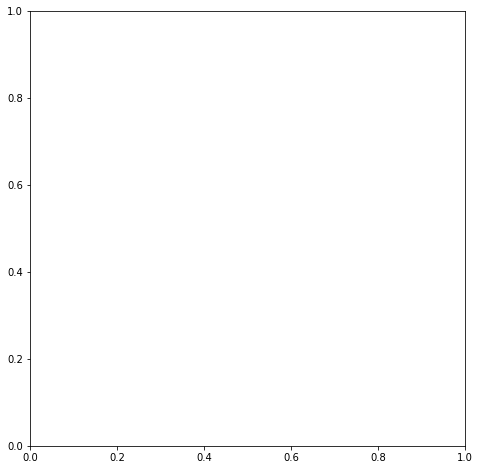

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
DF_neighbourhoods_shape.loc[:,:].plot(column = "AREA_S_CD", ax =ax, cmap = "viridis", legend = True)

**Extracting population x neighbourhood**

In [ ]:
DF_neighbourhoods_info = pd.read_csv("Data/neighbourhood-profiles-2016-csv.csv")
DF_neighbourhoods_info.head()

In [ ]:
# Population by neighbourhood as of 2016 (the most recent)
pop_by_neigh_2016 = DF_neighbourhoods_info.loc[2,:]
pop_by_neigh_2016 = pop_by_neigh_2016.iloc[6:]
pop_by_neigh_2016 = pop_by_neigh_2016.str.replace(r',','').astype(int)

In [20]:
# filter pop_by_neigh by subset of neighbourhoods
DF_neighbourhoods_shape["POP"] = DF_neighbourhoods_shape.apply(lambda row: pop_by_neigh_2016.filter(like = row.AREA_NAME, axis = 0).values[0], axis = 1)

NameError: ("name 'pop_by_neigh_2016' is not defined", 'occurred at index 0')

## OSM Data

In [21]:
# http://polygons.openstreetmap.fr/index.py?id=43992 , polygon creation from osm id (turin = 43992)
boundary_toronto = gpd.read_file("Data/Toronto.geojson")
#bbox = boundary_turin.envelope 
#df_bbox = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns = ["geometry"])
#intersections = gpd.overlay(df_bbox, DF_roads_turin, how = "intersection")

In [22]:
# bbox = (7.25,44.8,8.1,45.4)
DF_roads_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_roads_free_1.shp", bbox = boundary_toronto)
DF_buildings_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_buildings_a_free_1.shp", bbox = boundary_toronto)
# ferrovie di treni e tram
DF_railway_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_railways_free_1.shp", bbox = boundary_toronto)
#parcheggi, anche multipiano
DF_parking_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_traffic_a_free_1.shp", bbox = boundary_toronto)

# just in case
DF_churches_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_pofw_a_free_1.shp", bbox = boundary_toronto)
# ospedali, parchi, teatri 
DF_public_places_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_pois_a_free_1.shp", bbox = boundary_toronto)
# DF_public_places_toronto[DF_public_places_toronto.fclass == "hospital"]
# stazioni ferroviarie, fermate bus, tram, traghetto (lol?), taxi 
DF_transport_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_transport_a_free_1.shp", bbox = boundary_toronto)

DriverError: Data/ontario-latest-free.shp/gis_osm_roads_free_1.shp: No such file or directory

In [121]:
DF_roads_toronto.to_file("Data/Toronto_final/Roads_Toronto.shp")
DF_buildings_toronto.to_file("Data/Toronto_final/Buildings_Toronto.shp")

In [122]:
DF_public_places_toronto[DF_public_places_toronto.fclass == "hospital"].to_file("Data/Toronto_final/Hospitals_toronto.shp")


In [123]:
print(DF_roads_toronto.shape)
print(DF_buildings_toronto.shape)
print(DF_railway_toronto.shape)
print(DF_parking_toronto.shape)

(134309, 11)
(504997, 6)
(4256, 8)
(15743, 5)


In [142]:
"""
# matplotlib qt permette di avere una figura interattiva
# %matplotlib qt

#%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 20))
DF_roads_toronto.plot(ax = ax, alpha = 0.4, color = "black")
DF_buildings_toronto.plot(ax = ax, alpha = 0.8, color = "orange")
DF_public_places_toronto.plot(ax = ax , alpha = 0.6, color = "pink")
DF_parking_toronto.plot(ax = ax, alpha = 0.7, color = "blue")
DF_churches_toronto.plot(ax = ax, alpha = 0.7, color = "green")
DF_railway_toronto.plot(ax = ax, alpha = 0.4, color = "red")
#fig.savefig("Data/Toronto_Net.png", dpi = 1200)
""";

## [3D Massing Data](https://ckan0.cf.opendata.inter.prod-toronto.ca/tl/dataset/3d-massing)

In [24]:
height_buildings = gpd.read_file("C:/Users/Alessandro/Desktop/GAMA/Workspace/mas/includes/Data/Buildings/3DMassingShapefile_2019_WGS84/3DMassing_2019_WGS84.shp")
# There was a mismatch in zoning and buildings coordinates
# we need to reproject buildings in order to compare coordinates
# zoning epsg:4326 --> the correct one
height_buildings = height_buildings.to_crs(epsg= 4326)

CPLE_OpenFailedError: Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.

In [565]:
# filtering useful columns
height_buildings = height_buildings.loc[:, height_buildings.columns.intersection(['AVG_HEIGHT','LONGITUDE', 'geometry', 'LATITUDE', 'POLY_AREA', "PERIMETER"])]

In [570]:
height_buildings = height_buildings.reset_index()


In [573]:
height_buildings = height_buildings.rename(columns = {"index":"ID"})


In [574]:
height_buildings.head()


,ID,AVG_HEIGHT,LONGITUDE,LATITUDE,POLY_AREA,PERIMETER,geometry
0,0,7.3090,-79.592266,43.660304,1906.173775,180.218234,"POLYGON Z ((-79.59232 43.66001 0.00000, -79.59..."
1,1,8.2040,-79.588970,43.663573,1434.416417,220.001068,"POLYGON Z ((-79.58917 43.66356 0.00000, -79.58..."
2,2,4.1913,-79.588479,43.664104,612.515578,111.077719,"POLYGON Z ((-79.58869 43.66403 0.00000, -79.58..."
3,3,4.8489,-79.583894,43.660113,413.462391,89.451738,"POLYGON Z ((-79.58409 43.66014 0.00000, -79.58..."
4,4,5.9776,-79.584291,43.658825,263.809671,68.827410,"POLYGON Z ((-79.58443 43.65886 0.00000, -79.58..."


In [ ]:
# average apartment : 50 square meters
# altezza soffitto per legge: sopra i 2.3 metri --> mettere la media poco sopra a questo 
# per mettere le persone negli edifici (ref: http://www.buildingcode.online/1267.html)

In [439]:
"""
fig, ax = plt.subplots(1, 1, figsize = (15,8))
height_buildings.plot(column = "AVG_HEIGHT", ax = ax, linewidth=0.2 , legend = True, cmap = "viridis",
                    vmin=height_buildings.MAX_HEIGHT.min(), vmax=height_buildings.MAX_HEIGHT.max())
#fig.savefig("Data/Buildings_Height.png", dpi = 600)
""";

## [Zoning By Law](https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/zoning-by-law)

Ref: https://www.toronto.ca/wp-content/uploads/2017/10/9706-City-Planning-Zoning-city-wide-zoning-map.pdf

In [567]:
zoning = gpd.read_file("Data/Buildings/ZoningByLaw/ZONING_ZONE_CATAGORIES_WGS84.shp")


In [568]:
# There are some NaN values, replace them with "UNASSIGNED" zone category - which is OK 
zoning["ZN_ZONE"] = zoning["ZN_ZONE"].fillna("UNASSIGNED")
zoning["ZN_ZONE"] = zoning["ZN_ZONE"].replace("TBD","UNASSIGNED")
#zoning["ZN_ZONE"] = zoning["ZN_ZONE"].replace(None,"UNASSIGNED")
# Encoding Zone categories, so that we have numbers and not strings, for plotting purposes
zoning["ZONE_LABEL"]  = LabelEncoder().fit_transform(zoning["ZN_ZONE"].astype(str))

### Explaining ZN_ZONE
zones_dict = {"R": "Residential", "RD":"Residential Detached", "RA": "Residential Apartment",
              "CR": "Commercial Residential" , "E":"Employment Industrial", "CRE":"Commercial Residential Employment",
               "O":"Open Space", "CL":"Commercial Local","OR":"Open Space Recreation","ON":"Open Space Natural",
              "RM":"Residential Multiple Dwelling","RAC":"Residential Apartment Commercial","IPW":"Institutional Place of Worship",
              "EL":"Employment Light Industrial", "RS":"Residential Semi Detached", "RT":"Residential Townhouse", "EH":"Employment Heavy Industrial",
             "UNASSIGNED":"UNKNOWN", "I": "Institutional General", "EO":"Employment Industrial Office", "OC":"Open Space Cemetery",
             "IS":"Institutional School", "IH":"Institutional Hospital", "UT" : "Utility and Transportation", 
              "IE":"Institutional Education", "U":"Utility", "OG" : "Open Space Golf Course", "OM":"Open Space Marina",
              "EC":"Employment Industrial Commercial" }

zoning["ZN_ZONE_EXT"] = zoning.ZN_ZONE.replace(zones_dict)

## Filtering useful columns for GAMA
zoning = zoning.loc[:, zoning.columns.intersection(['OBJECTID','ZN_ZONE', 'geometry', 'ZONE_LABEL', 'ZN_ZONE_EXT'])]
zoning.OBJECTID = zoning.OBJECTID - 1

In [594]:
index = 0
height_buildings.ZN_ZONE_EXT.values[row]

'UNKNOWN'

In [549]:
#Init, fully optimized approx 12 sec
#height_buildings["ZN_ZONE_EXT"] = height_buildings.index.apply(lambda row: zoning.ZN_ZONE_EXT.values[0] if zoning.geometry.values[0].contains(row.geometry) else "UNKNOWN"  , axis = 1)
height_buildings["ZN_ZONE_EXT"] = height_buildings.ID.apply(lambda row: zoning.ZN_ZONE_EXT.values[0] if zoning.geometry.values[0].contains(height_buildings.geometry.values[row]) else "UNKNOWN")

In [580]:
import collections
collections.Counter(height_buildings["ZN_ZONE_EXT"])

Counter({'UNKNOWN': 421525, 'Residential': 40})

In [642]:
type(zoning.geometry.values[8483])

In [648]:
# delete nonetype columns
# zoning = zoning[zoning.geometry != zoning.geometry.values[8483]]
# zoning = zoning.reset_index()

In [654]:
# for loop --> fermi a 8084
for index in tqdm(range(8459,zoning.shape[0]), total= zoning.shape[0] - 8459):
    height_buildings["ZN_ZONE_EXT"] = height_buildings.ID.apply(lambda row: zoning.ZN_ZONE_EXT.values[index]
                                                         if zoning.geometry.values[index].contains(height_buildings.geometry.values[row]) 
                                                         else height_buildings.ZN_ZONE_EXT.values[row] )

In [655]:
import collections
collections.Counter(height_buildings["ZN_ZONE_EXT"])

Counter({'Open Space Recreation': 906,
         'Employment Industrial': 7018,
         'Residential Semi Detached': 20379,
         'Residential Detached': 229850,
         'Employment Light Industrial': 2539,
         'Open Space Golf Course': 89,
         'Residential Townhouse': 8345,
         'Institutional General': 281,
         'UNKNOWN': 11419,
         'Institutional School': 668,
         'Commercial Residential': 16557,
         'Residential Multiple Dwelling': 42522,
         'Residential Apartment': 4930,
         'Utility and Transportation': 396,
         'Commercial Local': 297,
         'Institutional Hospital': 224,
         'Open Space Natural': 327,
         'Open Space Cemetery': 138,
         'Residential Apartment Commercial': 1337,
         'Employment Industrial Office': 664,
         'Institutional Education': 481,
         'Employment Industrial Commercial': 1,
         'Employment Heavy Industrial': 1470,
         'Institutional Place of Worship': 214,
    

In [656]:

height_buildings.ZN_ZONE_EXT = height_buildings["ZN_ZONE_EXT"].astype(object)


In [657]:
height_buildings.to_pickle("Data/Buildings/height_buildings.pkl")


In [610]:
#a = pd.read_pickle("Data/Buildings/height_buildings.pkl")


In [437]:
"""
fig, ax = plt.subplots(1, 1, figsize = (15,8))
zoning.plot(column = "ZONE_LABEL", ax = ax, cmap = "coolwarm", legend = True)
#fig.savefig("Data/toronto_zones.png", dpi = 1200)
""";

### Extracting traffic congestion time series
(https://www.tomtom.com/en_gb/traffic-index/toronto-traffic/)

In [3]:
time_ser_str1 = "0 55.714285714285715 L 5.523255813953488 59.42857142857143 L 11.046511627906977 59.42857142857143 L 16.569767441860463 70.57142857142857 L 22.093023255813954 98.42857142857143 L 27.61627906976744 120.71428571428571 L 33.13953488372093 141.14285714285714 L 38.66279069767442 102.14285714285714 L 44.18604651162791 59.42857142857143 L 49.70930385981912 39 L 55.23255813953488 29.714285714285715 L 60.75581395348837 22.285714285714285 L 66.27906976744185 14.857142857142858 L 71.80232558139535 7.428571428571429 L 77.32558139534883 3.7142857142857144 L 82.84883720930233 0 L 88.37209302325581 0 L 93.89535037144702 0 L 99.4186046511628 3.7142857142857144 L 104.94186046511628 29.714285714285715 L 110.46511627906976 61.285714285714285 L 115.98837209302326 85.42857142857143 L 121.51162790697674 63.142857142857146 L 127.03488372093024 50.142857142857146 L 132.55814106912143 55.714285714285715 L 138.08139534883722 65 L 143.60465269702843 68.71428571428571 L 149.12790697674419 79.85714285714286 L 154.65116279069767 100.28571428571429 L 160.17441860465115 113.28571428571429 L 165.6516472868217 117 L 171.22093023255815 87.28571428571429 L 176.74418604651163 59.42857142857143 L 182.26744339470284 40.857142857142854 L 187.7906976744186 31.571428571428573 L 193.3139534883721 27.857142857142858 L 198.8372093023256 22.285714285714285 L 204.36046511627907 14.857142857142858 L 209.88372093023256 7.428571428571429 L 215.40697674418604 3.7142857142857144 L 220.93023255813952 0 L 226.45348837209303 0 L 231.97674418604652 0 L 237.5 0 L 243.02325581395348 5.571428571428571 L 248.54651162790697 14.857142857142858 L 254.06976744186048 27.857142857142858 L 259.5930247900517 39 L 265.11628060400517 52 L 270.63953488372096 63.142857142857146 L 276.16279069767444 66.85714285714286 L 281.6860465116279 66.85714285714286 L 287.2093023255814 66.85714285714286 L 292.7325581395349 65 L 298.25581395348837 61.285714285714285 L 303.7790713016796 59.42857142857143 L 309.3023271156331 46.42857142857143 L 314.8255813953488 33.42857142857143 L 320.3488372093023 29.714285714285715 L 325.8720930232558 27.857142857142858 L 331.3953488372093 24.142857142857142 L 336.9186046511628 16.714285714285715 L 342.4418604651163 9.285714285714286 L 347.9651162790698 5.571428571428571 L 353.48837209302326 1.8571428571428572 L 359.01162790697674 0 L 364.5348837209302 0 L 370.0581395348837 0 L 375.5813953488372 1.8571428571428572 L 381.1046511627907 5.571428571428571 L 386.6279069767442 14.857142857142858 L 392.1511627906977 24.142857142857142 L 397.6744201388889 35.285714285714285 L 403.19767441860466 44.57142857142857 L 408.72093023255815 50.142857142857146 L 414.24418604651163 52 L 419.7674418604651 52 L 425.2906976744186 48.285714285714285 L 430.8139534883721 46.42857142857143 L 436.33720930232556 40.857142857142854 L 441.86046511627904 33.42857142857143 L 447.3837209302326 26 L 452.90697827842376 22.285714285714285 L 458.43023409237725 16.714285714285715 L 463.95348837209303 9.285714285714286 L 469.4767441860465 1.8571428571428572 L 475 0 L 480.5232558139535 0 L 486.04651162790697 0 L 491.56976744186045 0 L 497.09302325581393 7.428571428571429 L 502.6162790697674 37.142857142857146 L 508.13953488372096 74.28571428571429 L 513.6627906976744 102.14285714285714 L 519.1860465116279 68.71428571428571 L 524.7093023255813 44.57142857142857 L 530.2325596737726 42.714285714285715 L 535.7558139534884 46.42857142857143 L 541.2790713016796 46.42857142857143 L 546.8023255813954 57.57142857142857 L 552.3255813953489 79.85714285714286 L 557.84883874354 98.42857142857143 L 563.3720930232558 113.28571428571429 L 568.8953488372093 78 L 574.4186046511628 42.714285714285715 L 579.941861999354 27.857142857142858 L 585.4651162790698 22.285714285714285 L 590.9883720930233 16.714285714285715 L 596.5116279069767 9.285714285714286 L 602.0348837209302 5.571428571428571 L 607.5581395348837 3.7142857142857144 L 613.0813953488372 1.8571428571428572 L 618.6046511627907 0 L 624.1279069767442 0 L 629.6511627906976 5.571428571428571 L 635.1744186046511 39 L 640.6976744186046 79.85714285714286 L 646.2209302325581 111.42857142857143 L 651.7441860465116 78 L 657.2674433947028 53.857142857142854 L 662.7906976744187 50.142857142857146 L 668.3139534883721 53.857142857142854 L 673.8372093023256 52 L 679.3604651162791 63.142857142857146 L 684.8837209302326 89.14285714285714 L 690.4069767441861 109.57142857142857 L 695.9302325581396 128.14285714285714 L 701.453488372093 91 L 706.9767441860465 48.285714285714285 L 712.5 29.714285714285715 L 718.0232558139535 24.142857142857142 L 723.546511627907 16.714285714285715 L 729.0697689760982 11.142857142857142 L 734.5930232558139 3.7142857142857144 L 740.1162790697674 0 L 745.6395364179587 0 L 751.1627906976744 0 L 756.6860465116279 0 L 762.2093023255813 5.571428571428571 L 767.7325581395348 39 L 773.2558139534884 79.85714285714286 L 778.7790697674419 111.42857142857143 L 784.3023255813954 81.71428571428571 L 789.8255829295865 55.714285714285715 L 795.34883874354 53.857142857142854 L 800.8720930232558 57.57142857142857 L 806.3953488372093 55.714285714285715 L 811.9186046511628 66.85714285714286 L 817.4418604651163 94.71428571428571 L 822.9651162790698 113.28571428571429 L 828.4883720930233 133.71428571428572 L 834.0116279069767 96.57142857142857 L 839.5348837209302 55.714285714285715 L 845.0581395348837 35.285714285714285 L 850.5813953488372 27.857142857142858 L 856.1046511627907 20.428571428571427 L 861.6279069767442 13 L 867.1511627906976 5.571428571428571 L 872.6744186046511 1.8571428571428572 L 878.1976744186046 0 L 883.7209302325581 0 L 889.2441875807493 0 L 894.7674418604652 5.571428571428571 L 900.2906976744187 37.142857142857146 L 905.8139534883721 76.14285714285714 L 911.3372093023256 109.57142857142857 L 916.8604666505167 78 L 922.3837209302326 55.714285714285715 L 927.9069767441861 55.714285714285715"
time_ser_str1 = time_ser_str1.replace(" L ", ",")
time_ser_str1 = time_ser_str1.replace(" ", ",")
time_ser1 = np.array(list(map(float, time_ser_str1.split(','))))
time_ser1 = time_ser1.reshape((time_ser1.shape[0]//2, 2))

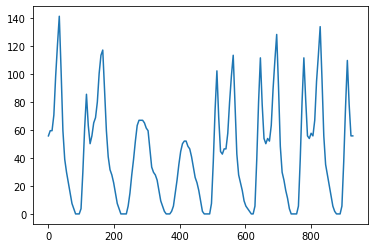

In [4]:
plt.plot(time_ser1[:,0], time_ser1[:,1])

In [5]:
time_ser_str2 = "0 33.42857142857143 L 5.523255813953488 35.285714285714285 L 11.046511627906977 35.285714285714285 L 16.569767441860463 42.714285714285715 L 22.093023255813954 63.142857142857146 L 27.61627906976744 65 L 33.13953488372093 63.142857142857146 L 38.66279069767442 57.57142857142857 L 44.18604651162791 39 L 49.70930385981912 27.857142857142858 L 55.23255813953488 16.714285714285715 L 60.75581395348837 9.285714285714286 L 66.27906976744185 5.571428571428571 L 71.80232558139535 1.8571428571428572 L 77.32558139534883 0 L 82.84883720930233 0 L 88.37209302325581 0 L 93.89535037144702 0 L 99.4186046511628 0 L 104.94186046511628 13 L 110.46511627906976 24.142857142857142 L 115.98837209302326 39 L 121.51162790697674 39 L 127.03488372093024 26 L 132.55814106912143 39 L 138.08139534883722 44.57142857142857 L 143.60465269702843 46.42857142857143 L 149.12790697674419 55.714285714285715 L 154.65116279069767 74.28571428571429 L 160.17441860465115 76.14285714285714 L 165.6516472868217 72.42857142857143 L 171.22093023255815 61.285714285714285 L 176.74418604651163 46.42857142857143 L 182.26744339470284 35.285714285714285 L 187.7906976744186 24.142857142857142 L 193.3139534883721 11.142857142857142 L 198.8372093023256 9.285714285714286 L 204.36046511627907 3.7142857142857144 L 209.88372093023256 0 L 215.40697674418604 0 L 220.93023255813952 0 L 226.45348837209303 0 L 231.97674418604652 0 L 237.5 0 L 243.02325581395348 0 L 248.54651162790697 5.571428571428571 L 254.06976744186048 11.142857142857142 L 259.5930247900517 20.428571428571427 L 265.11628060400517 29.714285714285715 L 270.63953488372096 42.714285714285715 L 276.16279069767444 46.42857142857143 L 281.6860465116279 50.142857142857146 L 287.2093023255814 50.142857142857146 L 292.7325581395349 48.285714285714285 L 298.25581395348837 42.714285714285715 L 303.7790713016796 37.142857142857146 L 309.3023271156331 31.571428571428573 L 314.8255813953488 27.857142857142858 L 320.3488372093023 16.714285714285715 L 325.8720930232558 9.285714285714286 L 331.3953488372093 7.428571428571429 L 336.9186046511628 3.7142857142857144 L 342.4418604651163 0 L 347.9651162790698 0 L 353.48837209302326 0 L 359.01162790697674 0 L 364.5348837209302 0 L 370.0581395348837 0 L 375.5813953488372 0 L 381.1046511627907 0 L 386.6279069767442 3.7142857142857144 L 392.1511627906977 7.428571428571429 L 397.6744201388889 14.857142857142858 L 403.19767441860466 20.428571428571427 L 408.72093023255815 27.857142857142858 L 414.24418604651163 29.714285714285715 L 419.7674418604651 29.714285714285715 L 425.2906976744186 29.714285714285715 L 430.8139534883721 26 L 436.33720930232556 24.142857142857142 L 441.86046511627904 22.285714285714285 L 447.3837209302326 20.428571428571427 L 452.90697827842376 16.714285714285715 L 458.43023409237725 5.571428571428571 L 463.95348837209303 3.7142857142857144 L 469.4767441860465 1.8571428571428572 L 475 0 L 480.5232558139535 0 L 486.04651162790697 0 L 491.56976744186045 0 L 497.09302325581393 0 L 502.6162790697674 14.857142857142858 L 508.13953488372096 26 L 513.6627906976744 39 L 519.1860465116279 39 L 524.7093023255813 22.285714285714285 L 530.2325596737726 27.857142857142858 L 535.7558139534884 27.857142857142858 L 541.2790713016796 29.714285714285715 L 546.8023255813954 37.142857142857146 L 552.3255813953489 52 L 557.84883874354 53.857142857142854 L 563.3720930232558 52 L 568.8953488372093 44.57142857142857 L 574.4186046511628 26 L 579.941861999354 20.428571428571427 L 585.4651162790698 11.142857142857142 L 590.9883720930233 5.571428571428571 L 596.5116279069767 3.7142857142857144 L 602.0348837209302 1.8571428571428572 L 607.5581395348837 0 L 613.0813953488372 0 L 618.6046511627907 0 L 624.1279069767442 0 L 629.6511627906976 1.8571428571428572 L 635.1744186046511 22.285714285714285 L 640.6976744186046 27.857142857142858 L 646.2209302325581 40.857142857142854 L 651.7441860465116 39 L 657.2674433947028 26 L 662.7906976744187 27.857142857142858 L 668.3139534883721 31.571428571428573 L 673.8372093023256 31.571428571428573 L 679.3604651162791 37.142857142857146 L 684.8837209302326 55.714285714285715 L 690.4069767441861 57.57142857142857 L 695.9302325581396 57.57142857142857 L 701.453488372093 50.142857142857146 L 706.9767441860465 29.714285714285715 L 712.5 22.285714285714285 L 718.0232558139535 13 L 723.546511627907 7.428571428571429 L 729.0697689760982 3.7142857142857144 L 734.5930232558139 0 L 740.1162790697674 0 L 745.6395364179587 0 L 751.1627906976744 0 L 756.6860465116279 0 L 762.2093023255813 0 L 767.7325581395348 27.857142857142858 L 773.2558139534884 33.42857142857143 L 778.7790697674419 46.42857142857143 L 784.3023255813954 46.42857142857143 L 789.8255829295865 27.857142857142858 L 795.34883874354 29.714285714285715 L 800.8720930232558 31.571428571428573 L 806.3953488372093 31.571428571428573 L 811.9186046511628 42.714285714285715 L 817.4418604651163 61.285714285714285 L 822.9651162790698 63.142857142857146 L 828.4883720930233 59.42857142857143 L 834.0116279069767 52 L 839.5348837209302 33.42857142857143 L 845.0581395348837 26 L 850.5813953488372 14.857142857142858 L 856.1046511627907 9.285714285714286 L 861.6279069767442 5.571428571428571 L 867.1511627906976 3.7142857142857144 L 872.6744186046511 0 L 878.1976744186046 0 L 883.7209302325581 0 L 889.2441875807493 0 L 894.7674418604652 0 L 900.2906976744187 16.714285714285715 L 905.8139534883721 29.714285714285715 L 911.3372093023256 48.285714285714285 L 916.8604666505167 46.42857142857143 L 922.3837209302326 29.714285714285715 L 927.9069767441861 29.714285714285715"
time_ser_str2 = time_ser_str2.replace(" L ", ",")
time_ser_str2 = time_ser_str2.replace(" ", ",")
time_ser2 = np.array(list(map(float, time_ser_str2.split(','))))
time_ser2 = time_ser2.reshape((time_ser2.shape[0]//2, 2))

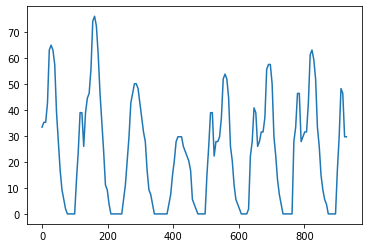

In [6]:
plt.plot(time_ser2[:,0], time_ser2[:,1])

In [7]:
time_ser_str3 = "0 29.714285714285715 L 5.523255813953488 33.42857142857143 L 11.046511627906977 33.42857142857143 L 16.569767441860463 42.714285714285715 L 22.093023255813954 65 L 27.61627906976744 72.42857142857143 L 33.13953488372093 66.85714285714286 L 38.66279069767442 57.57142857142857 L 44.18604651162791 37.142857142857146 L 49.70930385981912 26 L 55.23255813953488 13 L 60.75581395348837 7.428571428571429 L 66.27906976744185 3.7142857142857144 L 71.80232558139535 0 L 77.32558139534883 0 L 82.84883720930233 0 L 88.37209302325581 0 L 93.89535037144702 0 L 99.4186046511628 0 L 104.94186046511628 13 L 110.46511627906976 20.428571428571427 L 115.98837209302326 33.42857142857143 L 121.51162790697674 35.285714285714285 L 127.03488372093024 26 L 132.55814106912143 33.42857142857143 L 138.08139534883722 42.714285714285715 L 143.60465269702843 44.57142857142857 L 149.12790697674419 55.714285714285715 L 154.65116279069767 74.28571428571429 L 160.17441860465115 78 L 165.6516472868217 70.57142857142857 L 171.22093023255815 63.142857142857146 L 176.74418604651163 50.142857142857146 L 182.26744339470284 44.57142857142857 L 187.7906976744186 27.857142857142858 L 193.3139534883721 14.857142857142858 L 198.8372093023256 11.142857142857142 L 204.36046511627907 7.428571428571429 L 209.88372093023256 0 L 215.40697674418604 0 L 220.93023255813952 0 L 226.45348837209303 0 L 231.97674418604652 0 L 237.5 1.8571428571428572 L 243.02325581395348 1.8571428571428572 L 248.54651162790697 5.571428571428571 L 254.06976744186048 11.142857142857142 L 259.5930247900517 22.285714285714285 L 265.11628060400517 35.285714285714285 L 270.63953488372096 42.714285714285715 L 276.16279069767444 44.57142857142857 L 281.6860465116279 48.285714285714285 L 287.2093023255814 48.285714285714285 L 292.7325581395349 46.42857142857143 L 298.25581395348837 40.857142857142854 L 303.7790713016796 35.285714285714285 L 309.3023271156331 33.42857142857143 L 314.8255813953488 31.571428571428573 L 320.3488372093023 18.571428571428573 L 325.8720930232558 11.142857142857142 L 331.3953488372093 11.142857142857142 L 336.9186046511628 1.8571428571428572 L 342.4418604651163 0 L 347.9651162790698 0 L 353.48837209302326 0 L 359.01162790697674 0 L 364.5348837209302 0 L 370.0581395348837 0 L 375.5813953488372 0 L 381.1046511627907 0 L 386.6279069767442 3.7142857142857144 L 392.1511627906977 9.285714285714286 L 397.6744201388889 14.857142857142858 L 403.19767441860466 24.142857142857142 L 408.72093023255815 29.714285714285715 L 414.24418604651163 33.42857142857143 L 419.7674418604651 31.571428571428573 L 425.2906976744186 29.714285714285715 L 430.8139534883721 27.857142857142858 L 436.33720930232556 26 L 441.86046511627904 24.142857142857142 L 447.3837209302326 24.142857142857142 L 452.90697827842376 18.571428571428573 L 458.43023409237725 5.571428571428571 L 463.95348837209303 1.8571428571428572 L 469.4767441860465 0 L 475 0 L 480.5232558139535 0 L 486.04651162790697 0 L 491.56976744186045 0 L 497.09302325581393 0 L 502.6162790697674 16.714285714285715 L 508.13953488372096 29.714285714285715 L 513.6627906976744 37.142857142857146 L 519.1860465116279 37.142857142857146 L 524.7093023255813 22.285714285714285 L 530.2325596737726 24.142857142857142 L 535.7558139534884 29.714285714285715 L 541.2790713016796 29.714285714285715 L 546.8023255813954 35.285714285714285 L 552.3255813953489 50.142857142857146 L 557.84883874354 50.142857142857146 L 563.3720930232558 46.42857142857143 L 568.8953488372093 39 L 574.4186046511628 24.142857142857142 L 579.941861999354 20.428571428571427 L 585.4651162790698 14.857142857142858 L 590.9883720930233 9.285714285714286 L 596.5116279069767 5.571428571428571 L 602.0348837209302 3.7142857142857144 L 607.5581395348837 1.8571428571428572 L 613.0813953488372 0 L 618.6046511627907 0 L 624.1279069767442 0 L 629.6511627906976 0 L 635.1744186046511 16.714285714285715 L 640.6976744186046 27.857142857142858 L 646.2209302325581 40.857142857142854 L 651.7441860465116 39 L 657.2674433947028 26 L 662.7906976744187 27.857142857142858 L 668.3139534883721 29.714285714285715 L 673.8372093023256 31.571428571428573 L 679.3604651162791 37.142857142857146 L 684.8837209302326 57.57142857142857 L 690.4069767441861 57.57142857142857 L 695.9302325581396 52 L 701.453488372093 46.42857142857143 L 706.9767441860465 33.42857142857143 L 712.5 22.285714285714285 L 718.0232558139535 13 L 723.546511627907 7.428571428571429 L 729.0697689760982 5.571428571428571 L 734.5930232558139 3.7142857142857144 L 740.1162790697674 0 L 745.6395364179587 0 L 751.1627906976744 0 L 756.6860465116279 0 L 762.2093023255813 0 L 767.7325581395348 22.285714285714285 L 773.2558139534884 29.714285714285715 L 778.7790697674419 44.57142857142857 L 784.3023255813954 42.714285714285715 L 789.8255829295865 26 L 795.34883874354 29.714285714285715 L 800.8720930232558 31.571428571428573 L 806.3953488372093 31.571428571428573 L 811.9186046511628 37.142857142857146 L 817.4418604651163 63.142857142857146 L 822.9651162790698 78 L 828.4883720930233 87.28571428571429 L 834.0116279069767 72.42857142857143 L 839.5348837209302 35.285714285714285 L 845.0581395348837 22.285714285714285 L 850.5813953488372 13 L 856.1046511627907 7.428571428571429 L 861.6279069767442 5.571428571428571 L 867.1511627906976 1.8571428571428572 L 872.6744186046511 0 L 878.1976744186046 0 L 883.7209302325581 0 L 889.2441875807493 0 L 894.7674418604652 0 L 900.2906976744187 14.857142857142858 L 905.8139534883721 26 L 911.3372093023256 44.57142857142857 L 916.8604666505167 44.57142857142857 L 922.3837209302326 29.714285714285715 L 927.9069767441861 27.857142857142858"
time_ser_str3 = time_ser_str3.replace(" L ", ",")
time_ser_str3 = time_ser_str3.replace(" ", ",")
time_ser3 = np.array(list(map(float, time_ser_str3.split(','))))
time_ser3 = time_ser3.reshape((time_ser3.shape[0]//2, 2))

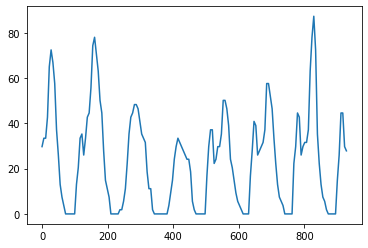

In [8]:
plt.plot(time_ser3[:,0], time_ser3[:,1])

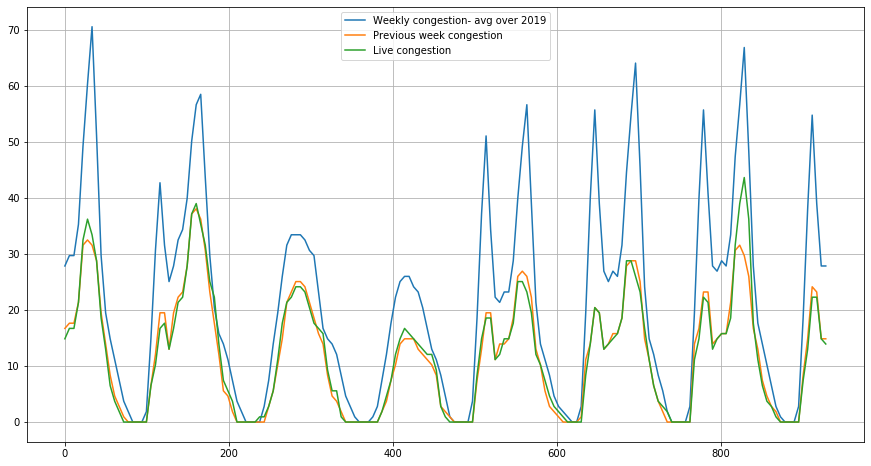

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
ax.grid()

ax.plot(time_ser1[:,0], time_ser1[:,1]/2, label = "Weekly congestion- avg over 2019")
ax.plot(time_ser2[:,0], time_ser2[:,1]/2, label = "Previous week congestion")
# Si parla della settimana 25 sept - 1 oct per la curva live congestion
ax.plot(time_ser3[:,0], time_ser3[:,1]/2, label = "Live congestion")
ax.legend();

In [10]:
# Così trasliamo il tempo, facendo partire la serie da lunedì notte
pt_1 = time_ser1[:88,1]
pt_2 = time_ser1[88:,1] 
time_ser1[:, 1] = np.hstack((pt_2,pt_1))/2
time_ser1 = time_ser1[:-1,:] 

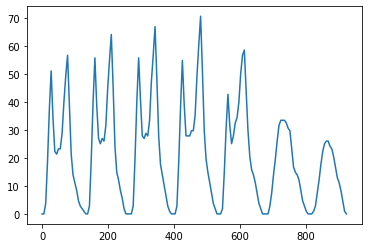

In [11]:
plt.plot(time_ser1[:,0], time_ser1[:,1])

In [12]:
### Dobbiamo decrittare l'encoding temporale, fortunatamente si hanno dei riferimenti sul sito
### i picchi corrispondono a ore precise e così si ricostruisce la singola giornata 
#time_ser1[87,1].max() # 5 pm di giovedì 
#time_ser1[77,1] # 8 am di giovedì
# dobbiamo rimuovere un elemento per avere una perfetta divisione in giorni 
# time_ser1[:-1,1].shape[0]/7 = 24.0

day1 = time_ser1[:24,:]
day2 = time_ser1[24:48,:]
day3 = time_ser1[48:72,:]
day4 = time_ser1[72:96,:]
day5 = time_ser1[96:120,:]
day6 = time_ser1[120:144,:]
day7 = time_ser1[144:,:]

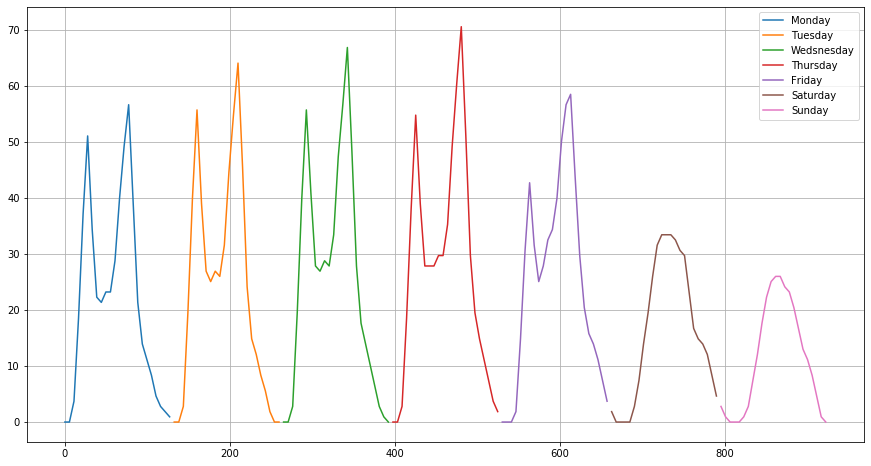

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
ax.grid()

ax.plot(day1[:,0], day1[:,1], label = "Monday")
ax.plot(day2[:,0], day2[:,1], label = "Tuesday")
ax.plot(day3[:,0], day3[:,1], label = "Wedsnesday")
ax.plot(day4[:,0], day4[:,1], label = "Thursday")
ax.plot(day5[:,0], day5[:,1], label = "Friday")
ax.plot(day6[:,0], day6[:,1], label = "Saturday")
ax.plot(day7[:,0], day7[:,1], label = "Sunday")


ax.legend();
#fig.savefig("traffic_congestion.png")

In [14]:
week = np.concatenate((day1,day2,day3,day4,day5,day6,day7))
np.savetxt("trafficweek.shp",week)

numpy.ndarray